In [1]:
import pandas as pd
import numpy as np
import glob
import os
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import umap.umap_ as umap
from sklearn.cluster import AgglomerativeClustering
import matplotlib.font_manager as fm
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings("ignore")

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [11]:
# Set path to your CSV files
csv_dir = "/content/drive/MyDrive/Dublin/10sec/Analysis/video_complixity/*.csv"  # 8K60FPS_Link is a shortcut folder to the VEDIA dataset

# Get sorted list of CSV files
all_files = sorted(glob.glob(csv_dir))

# Initialize list to store DataFrames
dfs = []

for file in all_files:
    try:
        if 'vmaf' in file:
            continue
        # Extract video number from filename (assuming format: 000_videoname.csv)
        filename = os.path.basename(file)
        video_number = int(filename.split('_')[0])  # First part is numeric

        # Read CSV and add video number column
        df = pd.read_csv(file)
        df['video_number'] = video_number
        df['video_id'] = f"{video_number:03d}_10s"


        dfs.append(df)

    except Exception as e:
        print(f"Error processing {file}: {str(e)}")
        continue

# Concatenate all DataFrames
combined_df = pd.concat(dfs, ignore_index=True)

# Optional: Verify results
print(f"Combined DataFrame shape: {combined_df.shape}")
print("Number of unique videos:", len(combined_df['video_number'].unique()))

Combined DataFrame shape: (43050, 23)
Number of unique videos: 80


In [5]:
# viewing loaded data
combined_df.head(10)

,Frame,SI,TI,Contrast,Brightness,Sharpness,Blockiness,TextureComplexity,ColorVar_U,ColorVar_V,...,Entropy,EntropyDiff,MotionIntensityDiff,EdgeDirectionality,AvgMotionXAxis,AvgMotionYAxis,StdMotionXAxis,StdMotionYAxis,video_number,video_id
0,0,117.6739,0.0000,191.375,0.4800,703.5,84.6250,0.3258,2486.0,381.50,...,6.9304,0.0000,0.0000,4.1365,0.0000,0.0000,0.0000,0.0000,120,120_10s
1,1,117.5713,9.1328,191.375,0.4795,701.5,84.6250,0.3261,2482.0,381.00,...,6.9302,0.0002,5.4219,4.1366,-0.1882,-0.0344,0.1877,0.1084,120,120_10s
2,2,117.3746,10.5391,191.375,0.4789,699.0,84.5625,0.3262,2478.0,380.75,...,6.9301,0.0001,6.0508,4.1367,-0.1622,-0.1268,0.1754,0.0870,120,120_10s
3,3,117.1585,10.0469,191.250,0.4778,696.0,84.5000,0.3261,2470.0,380.00,...,6.9297,0.0004,5.9375,4.1369,-0.2517,-0.0614,0.1700,0.1055,120,120_10s
4,4,117.0847,10.7344,191.250,0.4774,694.5,84.3750,0.3257,2474.0,380.00,...,6.9294,0.0003,6.2227,4.1368,-0.2759,0.1143,0.1586,0.0785,120,120_10s
5,5,117.0516,11.4688,191.250,0.4768,694.0,84.3750,0.3255,2464.0,379.50,...,6.9296,0.0002,6.6914,4.1369,-0.2727,0.0228,0.1664,0.1293,120,120_10s
6,6,117.2136,12.5781,191.125,0.4763,697.5,84.3125,0.3257,2462.0,380.00,...,6.9295,0.0001,7.1406,4.1368,-0.3105,0.0091,0.1438,0.0988,120,120_10s
7,7,117.3481,13.6797,191.125,0.4757,699.0,84.3750,0.3254,2456.0,378.50,...,6.9305,0.0010,7.5820,4.1369,-0.3032,0.1653,0.1554,0.1091,120,120_10s
8,8,117.4431,13.9453,191.125,0.4753,701.5,84.2500,0.3253,2454.0,378.50,...,6.9309,0.0004,7.6953,4.1369,-0.3254,0.1846,0.1627,0.0850,120,120_10s
9,9,117.4606,10.7344,191.125,0.4748,702.5,84.2500,0.3254,2452.0,377.00,...,6.9310,0.0001,6.0977,4.1369,-0.2455,0.0864,0.1768,0.0785,120,120_10s


In [13]:
# Custom aggregation functions
def linear_trend(s):
    x = np.arange(len(s))
    return np.polyfit(x, s, 1)[0] if len(s) > 1 else np.nan

def entropy(s):
    return skew(s) * kurtosis(s)  # Custom complexity measure

# Define the columns you want to keep

columns_to_use = [
  'Contrast',
  'Blockiness',
 'SI',
 'TI',
 'TextureComplexity',
 'Colorfulness',
 'Entropy',
 'AvgMotionXAxis',
 'AvgMotionYAxis',
 'video_number'
]

# Filter the DataFrame
filtered_df = combined_df[columns_to_use].copy()

# Confirm 'video_number' is present
assert 'video_number' in filtered_df.columns

# Define numeric columns (excluding 'video_number')
numeric_cols = filtered_df.select_dtypes(include=np.number).columns.difference(['video_number']).tolist()


# Define comprehensive aggregations
def safe_skew(x):
    if len(x) < 3 or x.std() < 1e-8:
        return np.nan
    return skew(x, bias=False)

def safe_kurtosis(x):
    if len(x) < 4 or x.std() < 1e-8:
        return np.nan
    return kurtosis(x, bias=False)

def stabilized_entropy(x):
    hist = np.histogram(x, bins='auto')[0].astype(float)
    hist += 1e-12  # Prevent zero probabilities
    hist /= hist.sum()
    return -np.sum(hist * np.log(hist))

def safe_hurst(x):
    if len(x) < 10 or np.std(x) < 1e-8:
        return np.nan
    return np.log(np.std(x) + 1e-12) / np.log(len(x))

def robust_autocorr(x):
    if len(x) < 2 or x.std() < 1e-8:
        return np.nan
    return x.autocorr(lag=1)

# Create the aggregation dictionary
agg_config = {
    col: [
        ('mean', lambda x: np.nanmean(x)),
        ('std', lambda x: np.nanstd(x)),
        ('range', lambda x: np.nanmax(x) - np.nanmin(x)),
        ('skew', safe_skew),
        ('kurt', safe_kurtosis),
        ('median', lambda x: np.nanmedian(x)),
        ('mad', lambda x: np.nanmean(np.abs(x - np.nanmean(x)))),
        ('trend', linear_trend),
        ('autocorr', robust_autocorr),
        ('fft1', lambda x: np.abs(np.fft.fft(x.fillna(0).values)[1]) if len(x) > 1 else np.nan),
        ('hurst', safe_hurst),
        ('nonlin', lambda x: np.nanmean(np.diff(x)**2))
    ]
    for col in numeric_cols
}

# Perform aggregation
agg_features = filtered_df.groupby('video_number').agg(agg_config)


# Flatten column names
agg_features.columns = [f"{col}_{stat}" for col, stat in agg_features.columns]

# Clean and clip the data
agg_features = agg_features.replace([np.inf, -np.inf], np.nan)
agg_features = agg_features.fillna(agg_features.mean())
agg_features = agg_features.clip(lower=agg_features.quantile(0.01),
                                 upper=agg_features.quantile(0.99), axis=1)


In [14]:
# viewing aggergated data
agg_features.head(10)

,AvgMotionXAxis_mean,AvgMotionXAxis_std,AvgMotionXAxis_range,AvgMotionXAxis_skew,AvgMotionXAxis_kurt,AvgMotionXAxis_median,AvgMotionXAxis_mad,AvgMotionXAxis_trend,AvgMotionXAxis_autocorr,AvgMotionXAxis_fft1,...,TextureComplexity_range,TextureComplexity_skew,TextureComplexity_kurt,TextureComplexity_median,TextureComplexity_mad,TextureComplexity_trend,TextureComplexity_autocorr,TextureComplexity_fft1,TextureComplexity_hurst,TextureComplexity_nonlin
video_number,,,,,,,,,,,,,,,,,,,,,
120,-0.113408,0.166599,0.8567,0.894552,0.695074,-0.141000,0.127834,-0.000002,0.916803,19.014434,...,0.0530,0.793625,-0.288364,0.28980,0.011473,-0.000079,0.999328,4.315207,-0.663422,2.851920e-07
121,-0.109400,1.592682,10.9863,1.491603,4.466414,-0.366850,1.172892,0.001200,0.929982,83.658865,...,0.1005,-0.691334,0.314777,0.20080,0.014551,-0.000030,0.874312,1.968296,-0.623044,8.694042e-05
122,0.084716,0.316001,2.0913,0.172817,-0.047113,0.103350,0.264237,0.000175,0.936701,19.817451,...,0.0127,-0.523710,1.358447,0.19575,0.001673,0.000004,0.994978,0.595812,-0.954288,5.011686e-08
123,-0.012798,0.183611,1.0271,-0.248276,-0.142483,-0.003450,0.147373,0.000102,0.923146,17.737140,...,0.1456,-2.148864,12.692211,0.38190,0.012292,0.000028,0.954377,3.218276,-0.627516,2.978880e-05
124,-1.162770,7.802875,45.7656,-0.062233,0.049948,-0.521950,6.204038,-0.003139,0.962255,350.260153,...,0.1664,-0.986145,2.646802,0.44305,0.017449,-0.000020,0.947208,5.595636,-0.577470,6.470000e-05
125,4.891995,1.519626,9.3438,0.137775,0.936763,4.740250,1.077325,0.002092,0.977067,210.640477,...,0.1333,0.869222,3.981115,0.17755,0.010810,-0.000013,0.938817,2.336737,-0.663482,2.507487e-05
126,-0.027147,0.353825,2.4433,-1.097083,2.595578,0.035200,0.273141,-0.000802,0.974328,58.625245,...,0.0756,-1.846040,3.695261,0.56320,0.010178,0.000021,0.933486,2.366551,-0.666888,2.624992e-05
127,-2.779456,6.184233,32.7148,-2.101153,4.919604,-0.776100,4.192014,0.002235,0.996671,489.132599,...,0.1347,0.236121,-0.860241,0.27605,0.028281,0.000067,0.925777,4.058908,-0.530133,1.683728e-04
128,0.025412,0.164624,0.9668,0.423822,0.478185,0.014900,0.128419,-0.000534,0.958156,54.311420,...,0.0863,0.238127,-1.779011,0.13415,0.035893,0.000167,0.995495,13.720584,-0.517622,1.200087e-05


In [15]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(agg_features)
features_scaled_df = pd.DataFrame(features_scaled, columns=agg_features.columns)

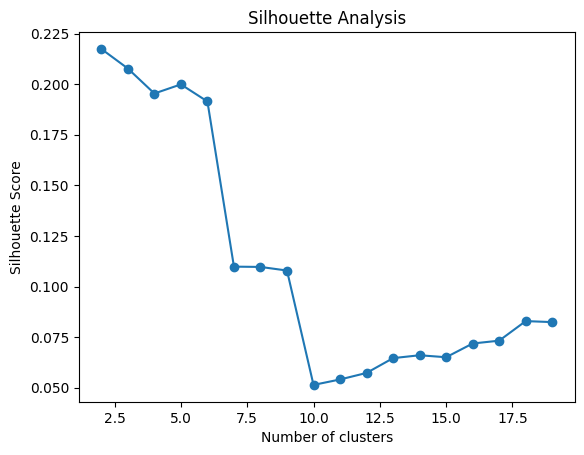

In [16]:
sil_scores = []
K_range = range(2, 20)

for k in K_range:
    model = AgglomerativeClustering(n_clusters=k).fit(features_scaled)
    labels = model.fit_predict(features_scaled)
    sil = silhouette_score(features_scaled, labels)
    sil_scores.append(sil)

plt.plot(K_range, sil_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.show()


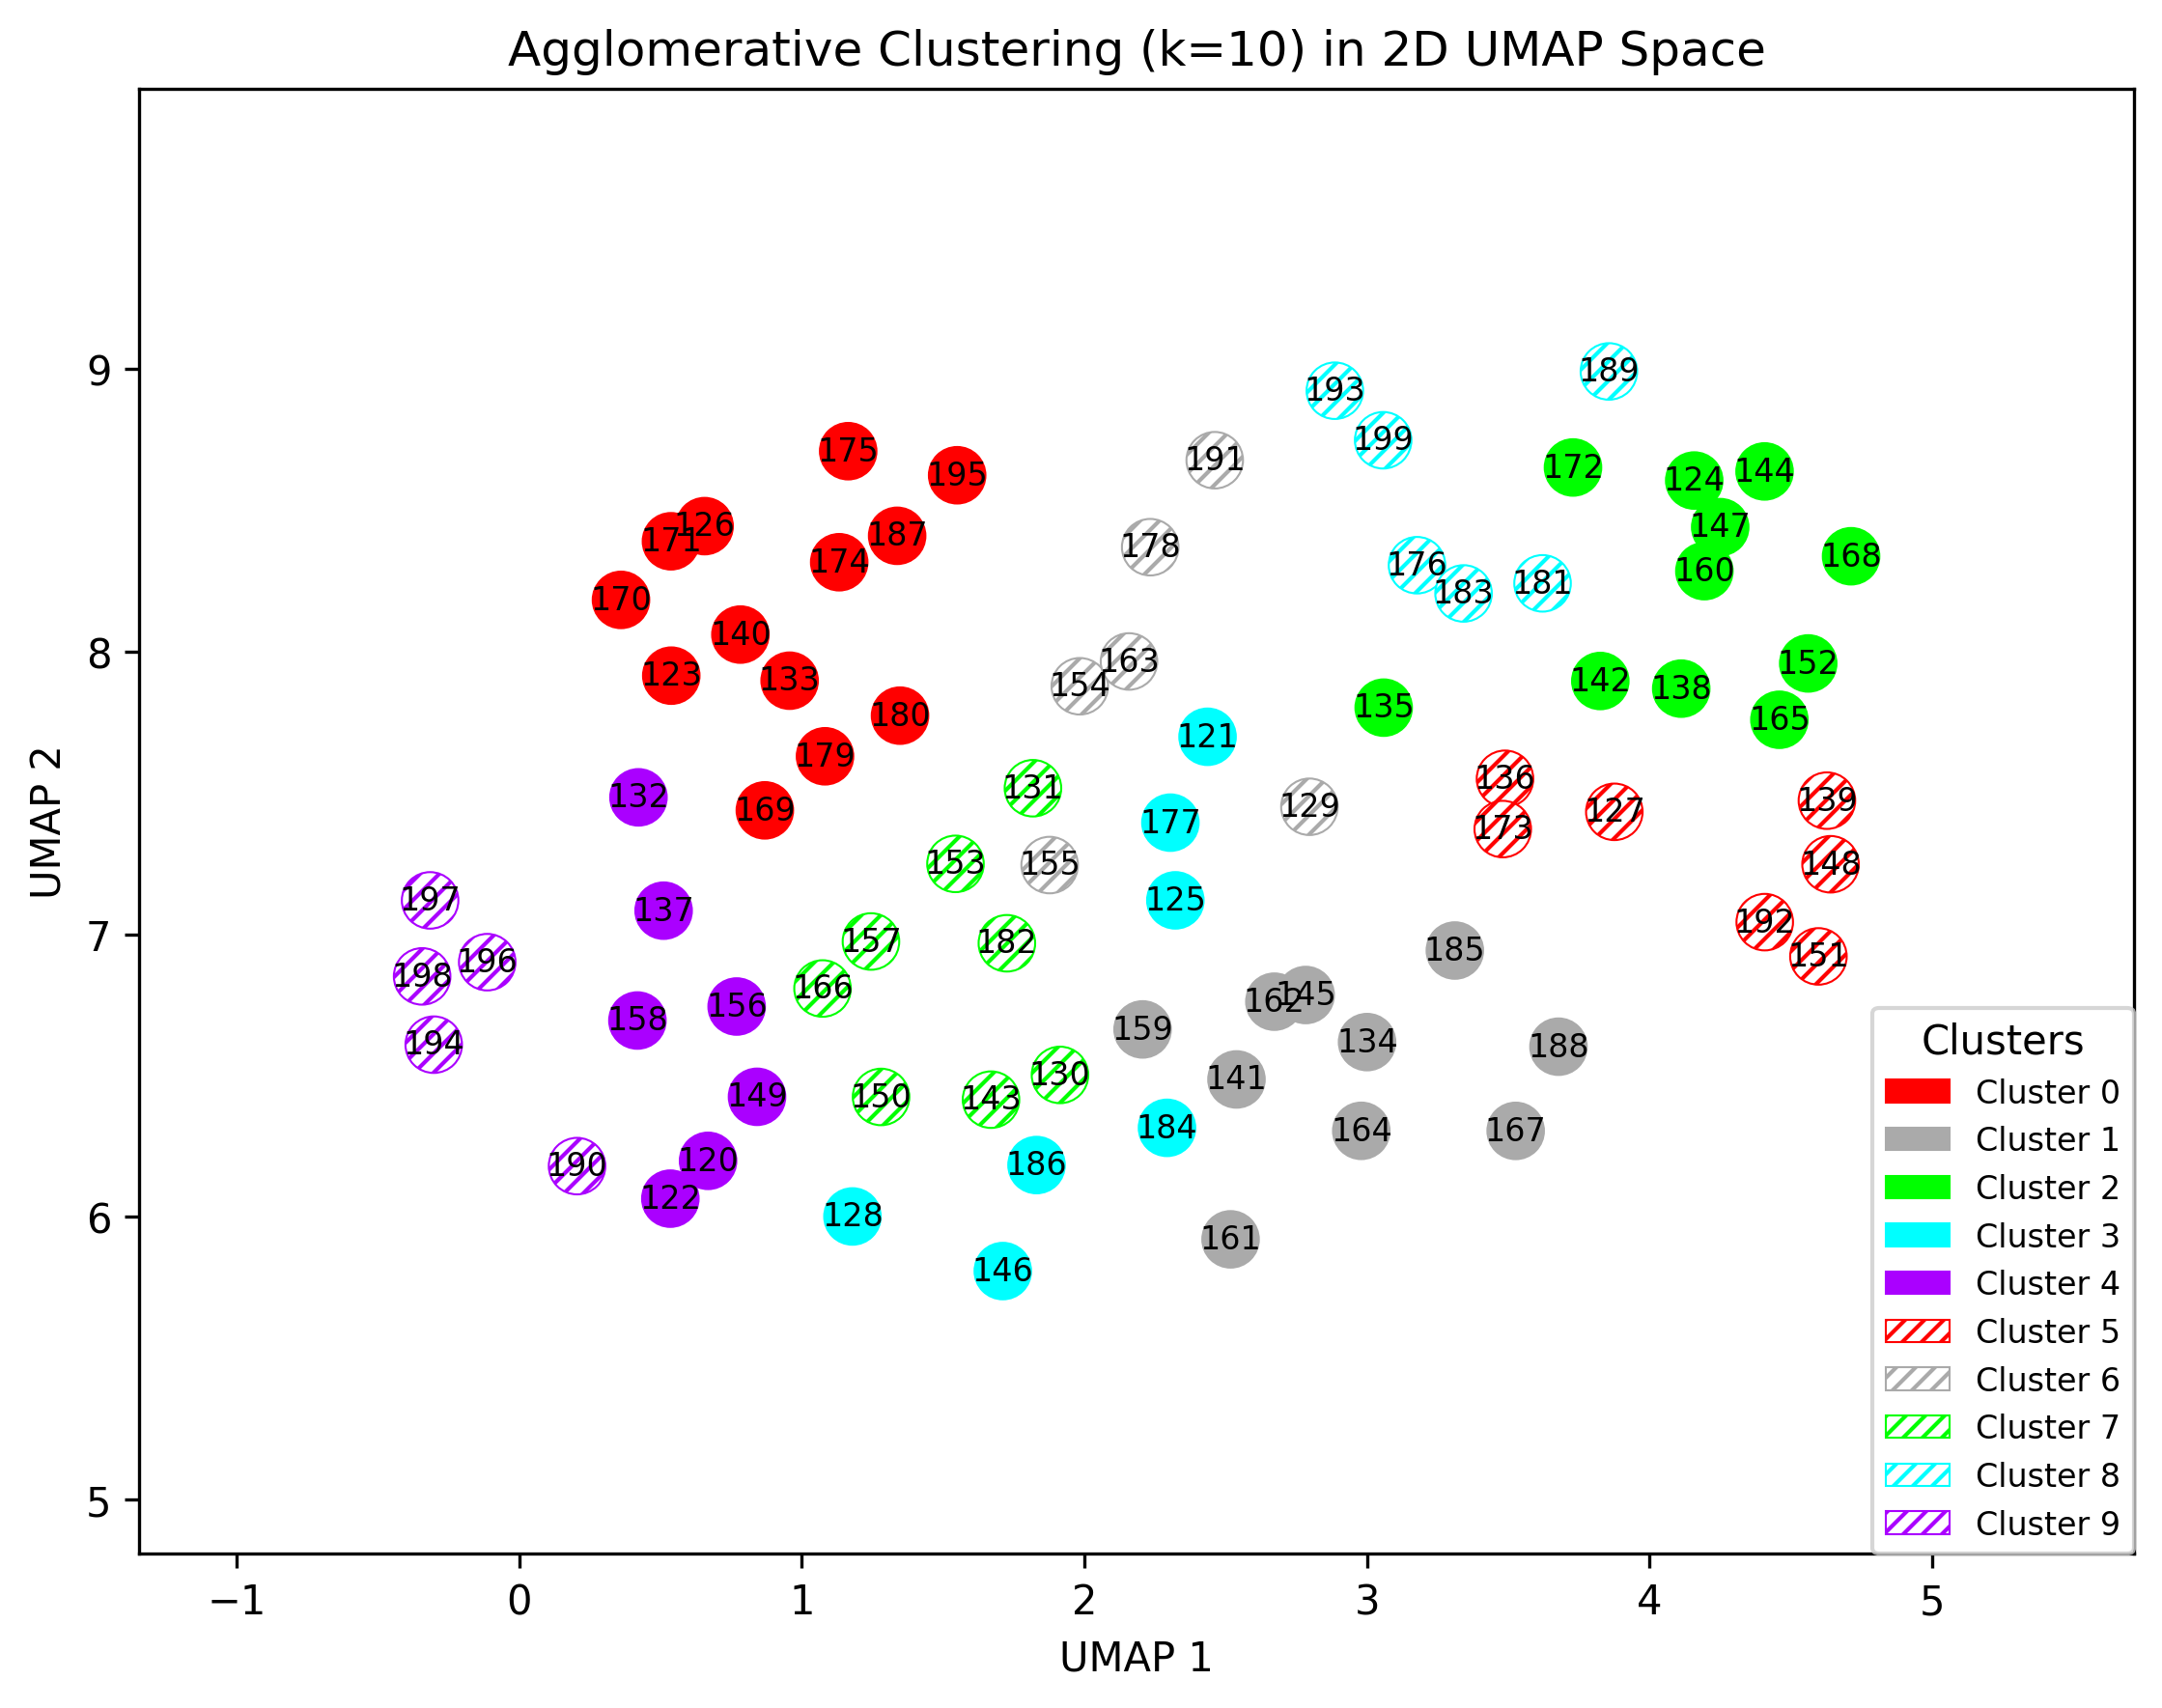

In [17]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.lines import Line2D
import numpy as np
import umap
from sklearn.cluster import AgglomerativeClustering
from matplotlib.patches import Patch


# Step 1: Reduce dimensions for clustering
umap_reducer = umap.UMAP(n_components=10, random_state=0)
features_reduced = umap_reducer.fit_transform(features_scaled)

# Step 2: Perform clustering
final_k = 10
model = AgglomerativeClustering(n_clusters=final_k)
labels = model.fit_predict(features_reduced)

# Step 3: UMAP again for 2D visualization
umap_2d = umap.UMAP(n_components=2, random_state=0)
X_2d = umap_2d.fit_transform(features_scaled)

# Base 5-color palette (RYGCB)
base_colors = ['#FF0000', '#AAAAAA', '#00FF00', '#00FFFF', '#AA00FF']
fill_styles = ['solid', 'hatch1', 'hatch2']
hatch_patterns = {'solid': None,
                  'hatch1': '/////',
                  'hatch2': 'xxxx'}

# Define plot
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

# Plot each point with pattern + color
for i in range(len(X_2d)):
    label = labels[i]
    color = base_colors[label % 5]
    fill_style = fill_styles[label // 5]
    hatch = hatch_patterns[fill_style]

    x, y = X_2d[i]
    circle = Circle((x, y), radius=0.1,
                    facecolor=color if hatch is None else 'white',
                    edgecolor=color,
                    hatch=hatch,
                    linewidth=.5,
                    alpha=1)
    ax.add_patch(circle)

    video_id = agg_features.index[i]
    ax.text(x, y, str(video_id), fontsize=8, ha='center', va='center', color='black')

# Axis settings
ax.set_title(f'Agglomerative Clustering (k={final_k}) in 2D UMAP Space')
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
ax.set_xlim(X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1)
ax.set_ylim(X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1)
ax.set_aspect('equal')

# Legend setup
legend_elements = []
for label in np.unique(labels):
    color = base_colors[label % 5]
    fill_style = fill_styles[label // 5]
    hatch = hatch_patterns[fill_style]

    legend_elements.append(Patch(
        facecolor=color if hatch is None else 'white',
        edgecolor=color,
        hatch=hatch,
        label=f'Cluster {label}',
        linewidth=0.5
    ))

legend = ax.legend(
    handles=legend_elements,
    title='Clusters',
    # bbox_to_anchor=(1.01, 1),
    fontsize=8,
    loc='lower right',
    borderaxespad=0.,
    handletextpad=0.8
)

# Set all legend text to black for consistency
for text in legend.get_texts():
    text.set_color('black')

plt.tight_layout()
plt.show()


In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Start with a DataFrame that includes video numbers and their assigned clusters
video_cluster_df = pd.DataFrame({
    'video_number': agg_features.index,
    'cluster': labels
})

# Stratified split by cluster
train_videos, test_videos = train_test_split(
    video_cluster_df,
    test_size=0.2,
    stratify=video_cluster_df['cluster'],
    random_state=0
)
train_video_ids = train_videos['video_number'].values
test_video_ids = test_videos['video_number'].values

In [19]:
print("Training video IDs:", train_video_ids)
print("Testing video IDs:", test_video_ids)
print("Number of training videos:", len(train_video_ids))
print("Number of testing videos", len(test_video_ids))
print("Train/Test ratio:", 100*len(train_video_ids) / (len(train_video_ids)+len(test_video_ids)), ":", 100*len(test_video_ids) / (len(train_video_ids)+len(test_video_ids)))

Training video IDs: [135 171 144 180 177 136 156 129 154 125 192 176 151 143 152 137 128 174
 170 124 198 162 142 191 185 175 199 189 167 184 132 186 181 169 138 161
 166 160 130 150 134 196 173 149 131 179 155 133 123 190 172 148 159 153
 197 188 126 121 147 163 145 193 127 158]
Testing video IDs: [122 182 146 168 195 164 165 157 194 183 139 120 178 140 187 141]
Number of training videos: 64
Number of testing videos 16
Train/Test ratio: 80.0 : 20.0


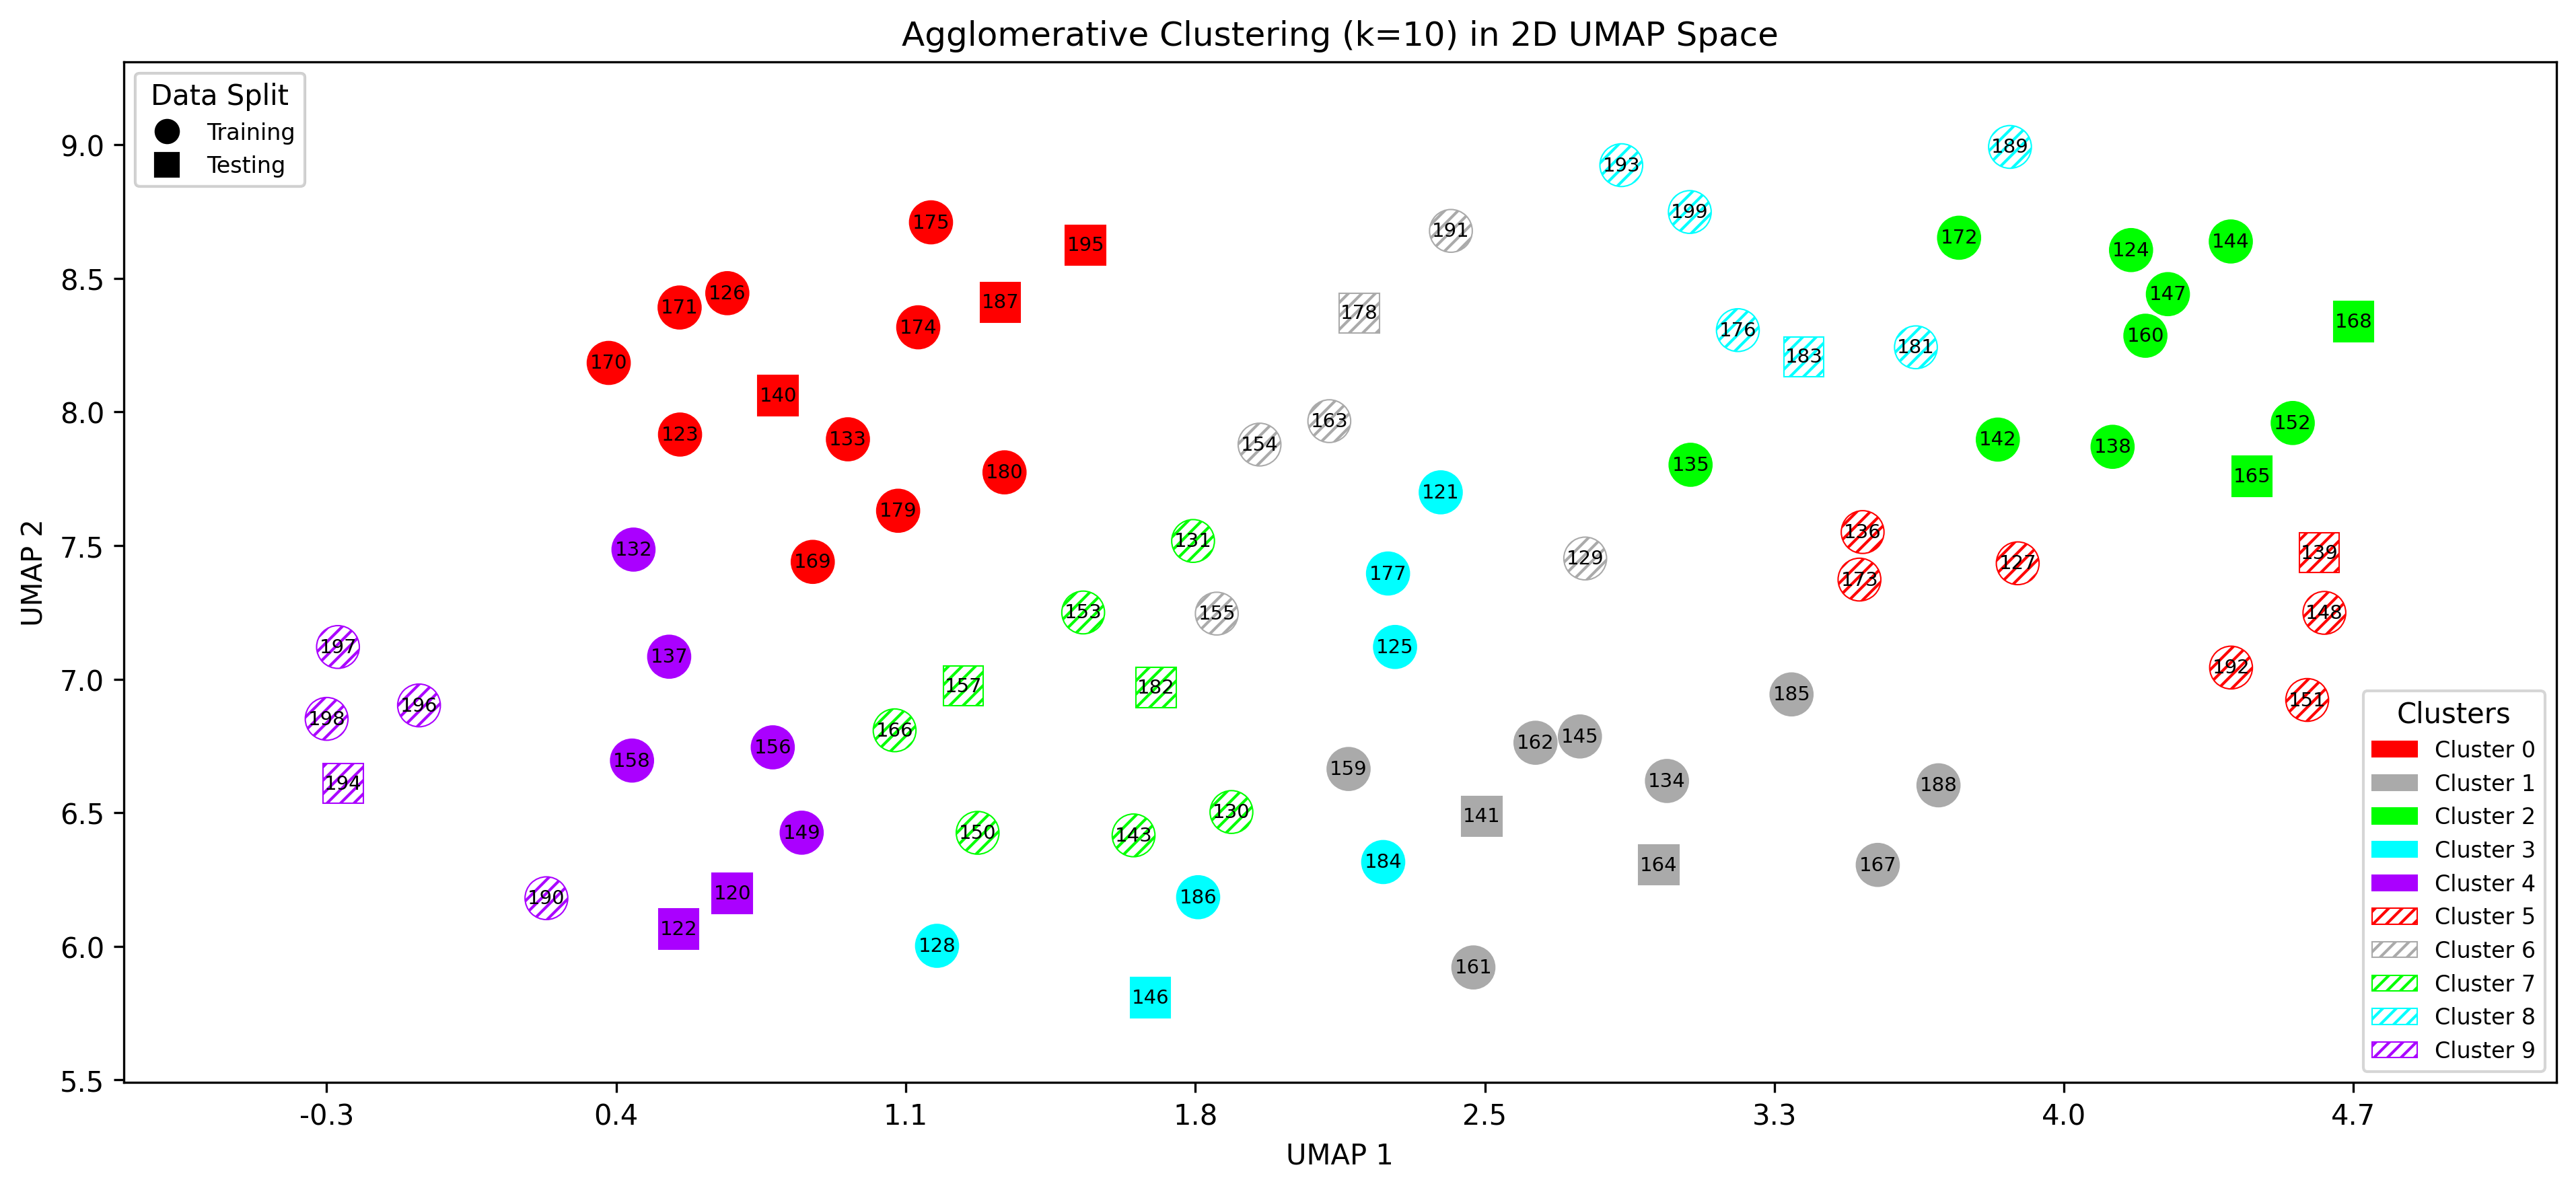

In [21]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle, Patch
from matplotlib.lines import Line2D
import numpy as np
import umap
from sklearn.cluster import AgglomerativeClustering

# UMAP dimensionality reduction
umap_2d = umap.UMAP(n_components=2, random_state=0)
X_2d = umap_2d.fit_transform(features_scaled)

# Stretch factor for X-axis (visual only)
x_stretch_factor = 1.5
X_plot = X_2d.copy()
X_plot[:, 0] *= x_stretch_factor  # Stretch only X values

# Cluster setup
final_k = 10
base_colors = ['#FF0000', '#AAAAAA', '#00FF00', '#00FFFF', '#AA00FF']
fill_styles = ['solid', 'hatch1', 'hatch2']
hatch_patterns = {'solid': None, 'hatch1': '/////', 'hatch2': 'xxxx'}

# Cluster model
model = AgglomerativeClustering(n_clusters=final_k)
labels = model.fit_predict(features_reduced)

# Masks
is_train = agg_features.index.isin(train_video_ids)

# Plot setup
fig, ax = plt.subplots(figsize=(20, 6), dpi=300)

label_offsets = {
    69: (-0.05, 0.05), 96: (0.05, -0.05), 23: (0.05, 0.05), 86: (-0.02, 0),
    64: (0.02, 0), 110: (-0.02, 0), 82: (0.02, 0), 28: (-0.02, 0.02),
    93: (0.01, 0), 24: (-0.01, 0), 46: (-0.02, 0.02), 50: (0.02, 0),
    25: (-0.01, -0.01)
}

for i in range(len(X_plot)):
    label = labels[i]
    color = base_colors[label % 5]
    fill_style = fill_styles[label // 5]
    hatch = hatch_patterns[fill_style]
    x, y = X_plot[i]

    if agg_features.index[i] in train_video_ids:
        marker = Circle((x, y), radius=0.08,
                        facecolor=color if hatch is None else 'white',
                        edgecolor=color, hatch=hatch,
                        linewidth=0.5, alpha=1)
    else:
        size = 0.15
        marker = Rectangle((x - size / 2, y - size / 2), width=size, height=size,
                           facecolor=color if hatch is None else 'white',
                           edgecolor=color, hatch=hatch,
                           linewidth=0.5, alpha=1)
    ax.add_patch(marker)

    video_id = agg_features.index[i]
    dx, dy = label_offsets.get(video_id, (0.0, 0.0))
    ax.text(x + dx, y + dy, str(video_id), fontsize=7, ha='center', va='center', color='black')

# Axes labels and title
ax.set_title(f'Agglomerative Clustering (k={final_k}) in 2D UMAP Space')
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')

# Axis limits (on stretched x-axis)
x_vals = X_plot[:, 0]
y_vals = X_plot[:, 1]
x_margin = (x_vals.max() - x_vals.min()) * 0.1
y_margin = (y_vals.max() - y_vals.min()) * 0.1
ax.set_xlim(x_vals.min() - x_margin, x_vals.max() + x_margin)
ax.set_ylim(y_vals.min() - y_margin, y_vals.max() + y_margin)

# Equal aspect, to keep shapes undistorted
ax.set_aspect('equal', adjustable='box')

# Custom tick labels to show original (unscaled) X values
xticks = np.linspace(x_vals.min(), x_vals.max(), num=8)
xticklabels = [f"{x / x_stretch_factor:.1f}" for x in xticks]
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)

# --- Legend 1: Cluster Colors & Patterns ---
legend_elements = []
for label in np.unique(labels):
    color = base_colors[label % 5]
    fill_style = fill_styles[label // 5]
    hatch = hatch_patterns[fill_style]
    legend_elements.append(Patch(
        facecolor=color if hatch is None else 'white',
        edgecolor=color,
        hatch=hatch,
        label=f'Cluster {label}',
        linewidth=0.5
    ))

legend1 = ax.legend(
    handles=legend_elements,
    title='Clusters',
    fontsize=8,
    loc='lower right',
    frameon=True
)
ax.add_artist(legend1)

# --- Legend 2: Data Split (Train/Test) ---
marker_handles = [
    Line2D([0], [0], marker='o', color='black', label='Training',
           markersize=8, linestyle='None'),
    Line2D([0], [0], marker='s', color='black', label='Testing',
           markersize=8, linestyle='None')
]
legend2 = ax.legend(
    handles=marker_handles,
    title='Data Split',
    fontsize=8,
    loc='upper left',
    frameon=True
)
ax.add_artist(legend2)

plt.tight_layout()
plt.show()


In [22]:
df_split = video_cluster_df.copy()

# Add 'split' column based on train/test membership
df_split['split'] = df_split['video_number'].apply(
    lambda x: 'train' if x in train_video_ids else 'test'
)
df_split['video_number'] = df_split['video_number'].apply(lambda x: f'{x:03d}_10s')

df_split.to_csv('10s_video_splits.csv', index=False)
